# Total Dissolved Solids (TDS) Analysis

A notebook for looking at TDS to see if any trends pop out regarding TDS. Starting from the hypothesis that it is relatively insignificant, being more akin to ratio than an indicator of taste/qualtiy. 


## TDS Collection Workfloe

No filtering is based on analysis done by [Socratic Coffee](http://socraticcoffee.com/2015/07/measuring-total-dissolved-solids-a-refractometer-comparison-part-iii-espresso-filters/) plus there was the desire to avoid wasting tons of plastic for investigations into things that don't seem super consistent to begin with (~1.75% difference in socratic coffee test while filtering).

Measured using the [Atago Coffee refractometer](https://www.atago.net/product/?l=en&f=products-pal-top.php#CGD50756)

1. Pull the shot
1. Stir shot with spoon for ~5 seconds
1. Extract 1.5ml of liquid using coffee syringe and place in cup to cool
1. Consume
1. Rinse coffee syringe (lets not waste a ton of syringes here)
1. Use distilled water syringe to zero Atago
1. Use rinsed coffee syringe to move cooled coffee (no filtering)
1. Collect data
1. Repeat

In [1]:
import os
import math

from collections import defaultdict
from tempfile import NamedTemporaryFile

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from optpresso import __file__ as optpresso_path
from optpresso.data.partition import find_test_paths

from IPython.core.display import display

In [2]:
OPTPRESSO_DIR = os.path.dirname(optpresso_path)
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv"
plt.rcParams["figure.dpi"] = 150

In [3]:
# Download CSV, won't work on windozes
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
# Clean up the CSV file.
for char in [' ', '(', ')', "%", "/", "\\", '"']:
    df.columns = df.columns.str.strip().str.lower().str.replace(char, '')
df = df[df["grinder"].astype(bool)][df["grindersetting"].astype(bool)]
# Only look at data with TDS values and ratings
invalid_indices = df[df["tdsatagounfiltered"].isna() | df["arbitraryrating1-10"].isna()].index
df.drop(invalid_indices, inplace=True)
df = df.assign(extraction_yield = df.tdsatagounfiltered * df.output / df.coffeegrams)

Fit func  
0.1067 x + 15.76


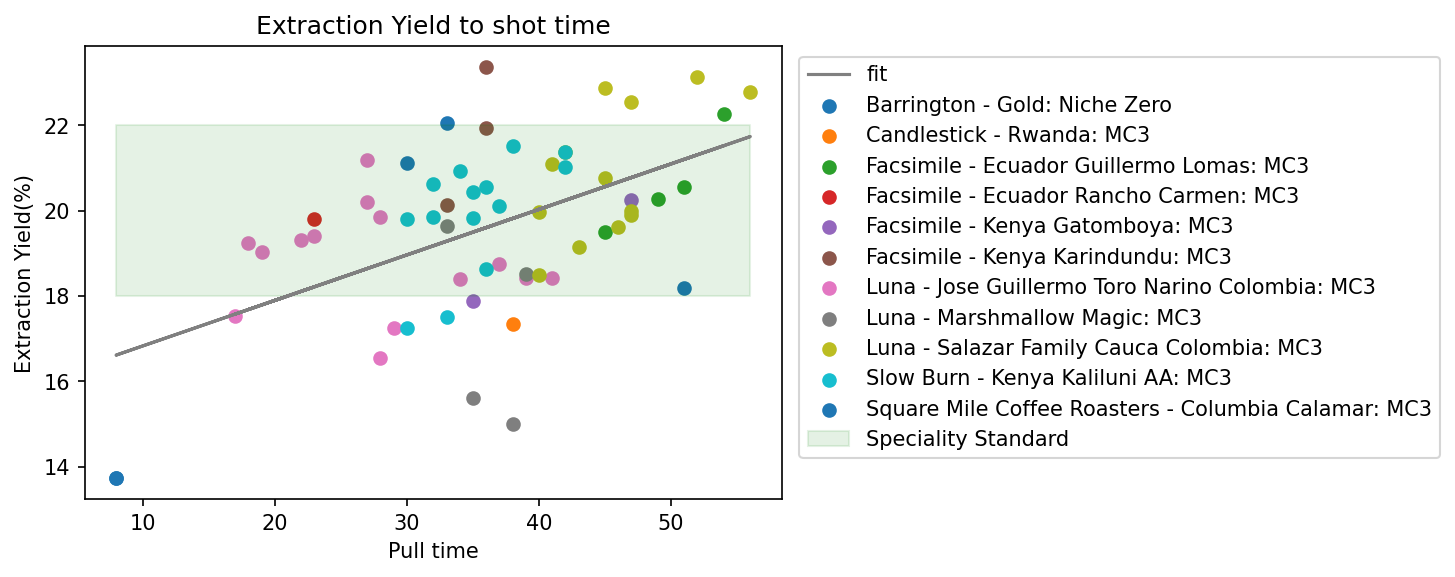

In [4]:
for name, subdf in df.groupby(["coffee", "grinder"]):
    plt.scatter(subdf.time, subdf.extraction_yield, label=": ".join(name))
ax = plt.gca()
ax.set_title("Extraction Yield to shot time")
ax.set_ylabel("Extraction Yield(%)")
ax.set_xlabel("Pull time")
poly_fit = np.poly1d(np.polyfit(df.time, df.extraction_yield, 1))
print("Fit func", poly_fit)
plt.plot(
    df["time"].unique(),
    poly_fit(df["time"].unique()),
    color="gray",
    linestyle="-",
    label="fit"
)
# http://www.scaa.org/?d=brewing-standards&page=resources
plt.fill_between([df["time"].min(), df["time"].max()], 18, 22, color='g', alpha=.1, label="Speciality Standard")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

RATINGS ARE SUBJECTIVE AND NOT CONSISTENTLY COLLECTED
Fit func  
0.3124 x + 17.91


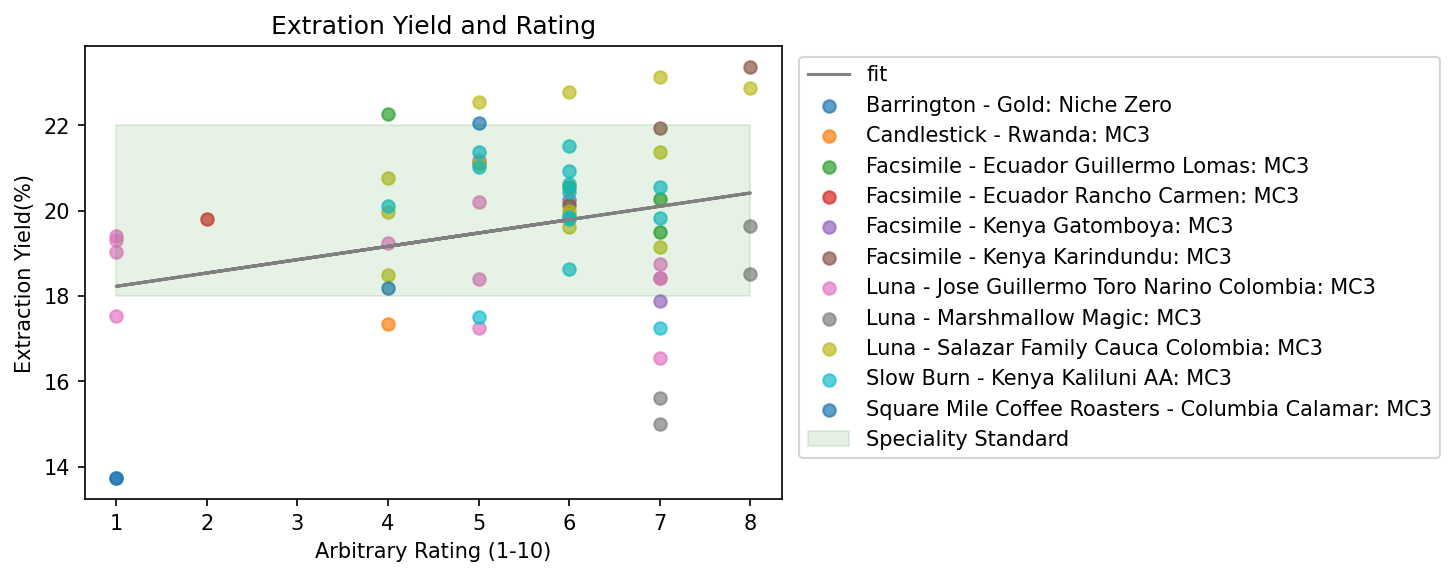

In [8]:
print("RATINGS ARE SUBJECTIVE AND NOT CONSISTENTLY COLLECTED")
for name, subdf in df.groupby(["coffee", "grinder"]):
    plt.scatter(subdf["arbitraryrating1-10"], subdf.extraction_yield, label=": ".join(name), alpha=.7)
ax = plt.gca()
ax.set_title("Extration Yield and Rating")
ax.set_ylabel("Extraction Yield(%)")
ax.set_xlabel("Arbitrary Rating (1-10)")
poly_fit = np.poly1d(np.polyfit(df["arbitraryrating1-10"], df.extraction_yield, 1))
print("Fit func", poly_fit)
plt.plot(
    df["arbitraryrating1-10"].unique(),
    poly_fit(df["arbitraryrating1-10"].unique()),
    color="gray",
    linestyle="-",
    label="fit"
)
# http://www.scaa.org/?d=brewing-standards&page=resources
plt.fill_between([df["arbitraryrating1-10"].min(), df["arbitraryrating1-10"].max()], 18, 22, color='g', alpha=.1, label="Speciality Standard")

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

RATINGS ARE SUBJECTIVE AND NOT CONSISTENTLY COLLECTED
Fit func  
2.973 x + 19.93


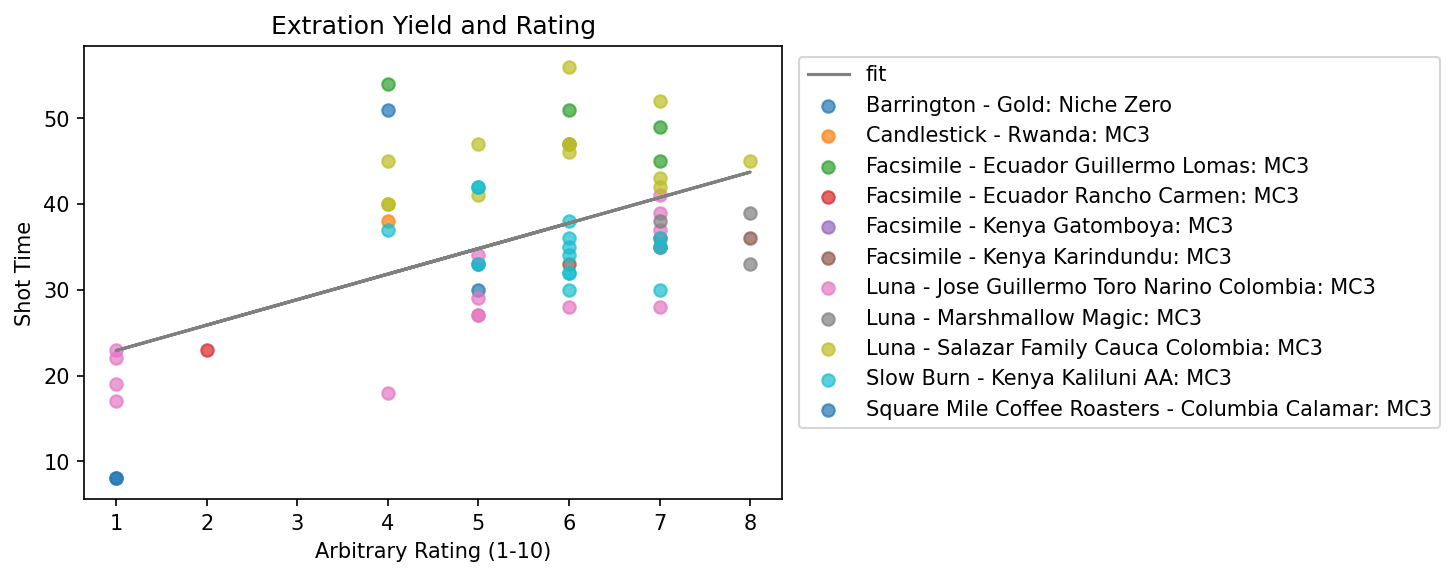

In [9]:
print("RATINGS ARE SUBJECTIVE AND NOT CONSISTENTLY COLLECTED")
for name, subdf in df.groupby(["coffee", "grinder"]):
    plt.scatter(subdf["arbitraryrating1-10"], subdf.time, label=": ".join(name), alpha=.7)
ax = plt.gca()
ax.set_title("Extration Yield and Rating")
ax.set_ylabel("Shot Time")
ax.set_xlabel("Arbitrary Rating (1-10)")
poly_fit = np.poly1d(np.polyfit(df["arbitraryrating1-10"], df.time, 1))
print("Fit func", poly_fit)
plt.plot(
    df["arbitraryrating1-10"].unique(),
    poly_fit(df["arbitraryrating1-10"].unique()),
    color="gray",
    linestyle="-",
    label="fit"
)

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

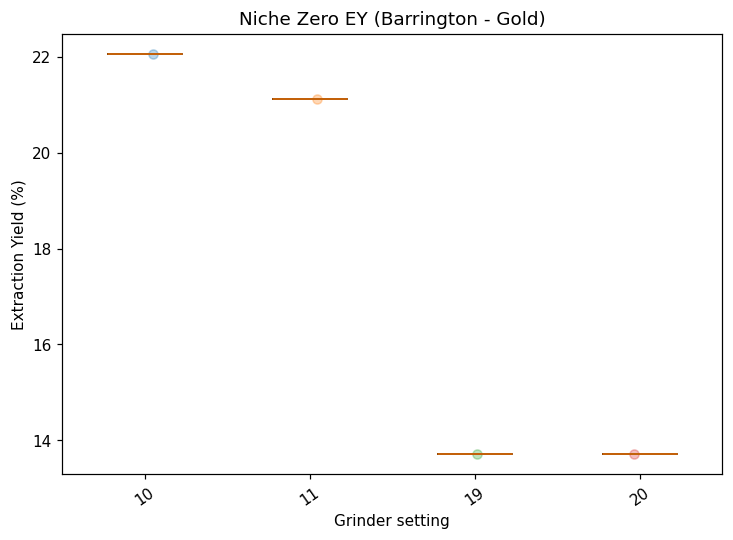

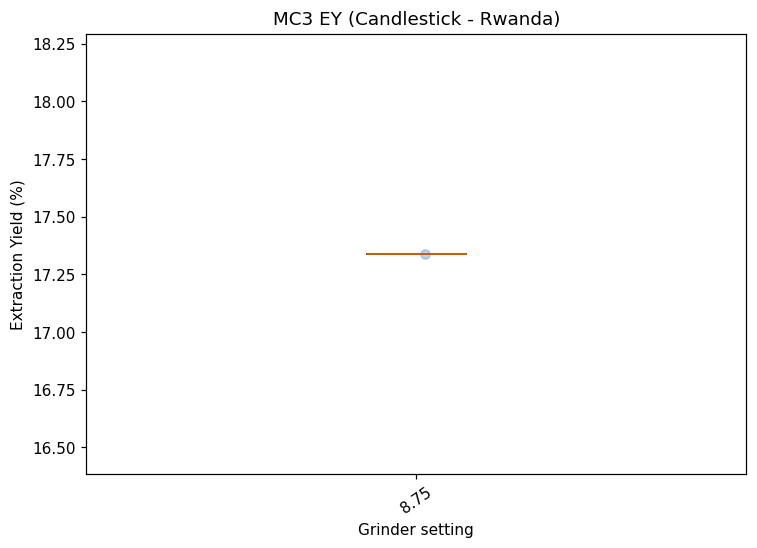

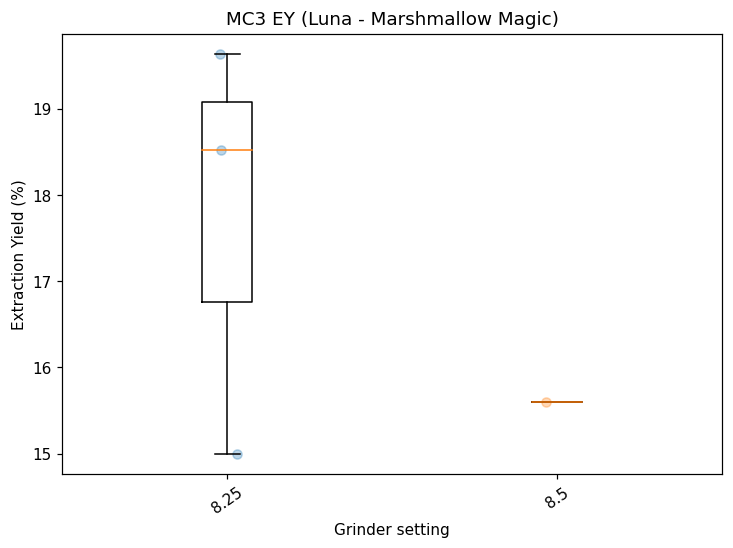

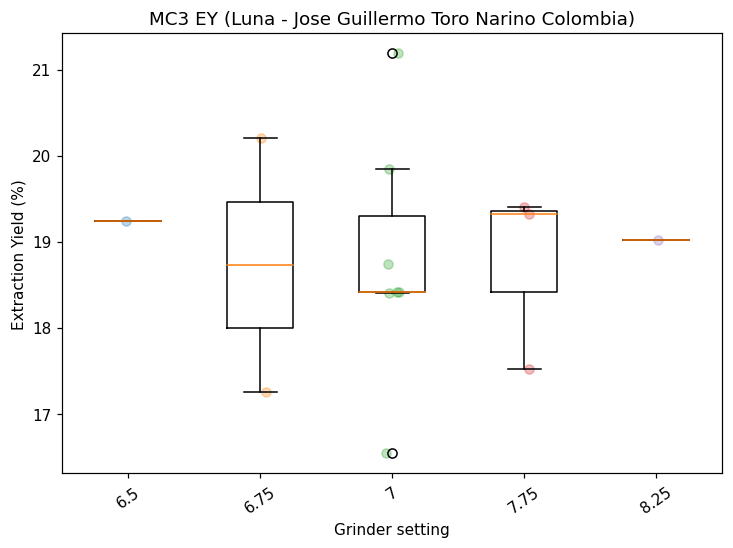

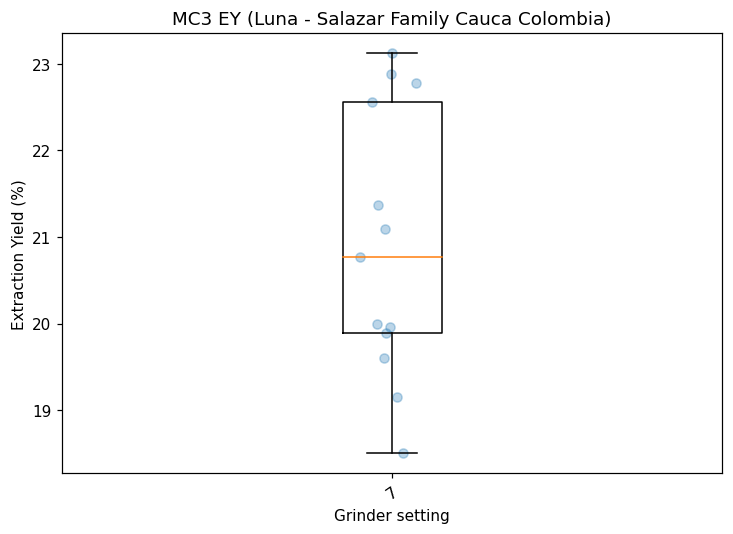

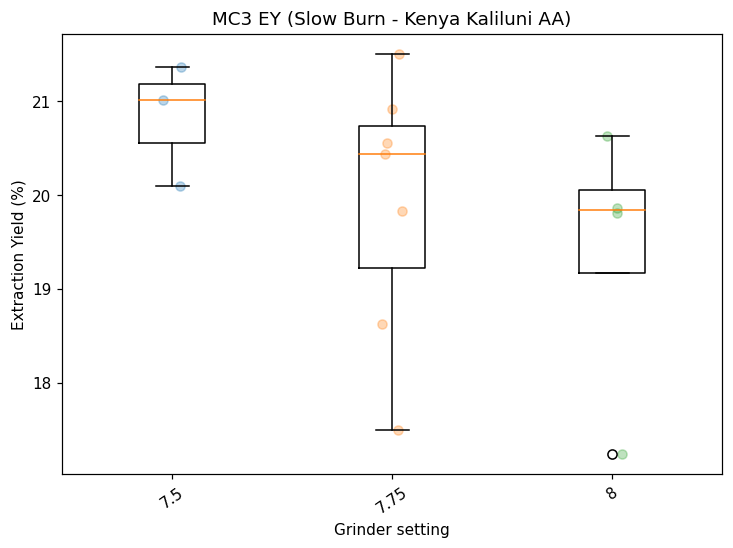

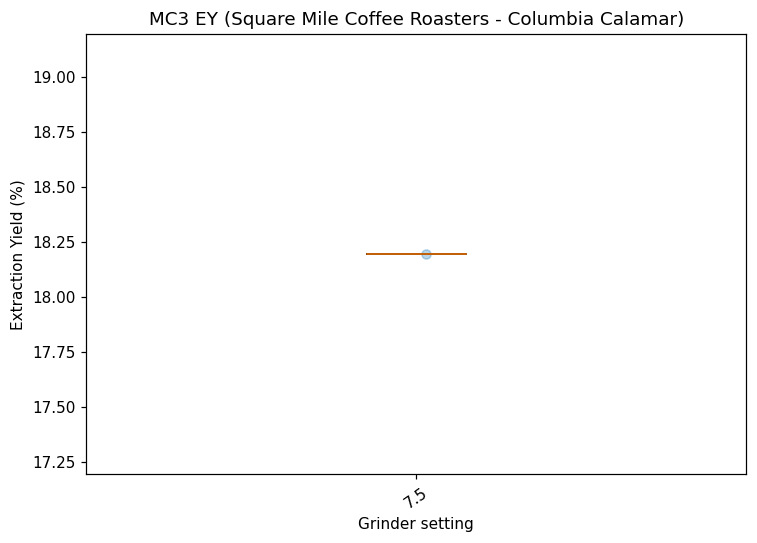

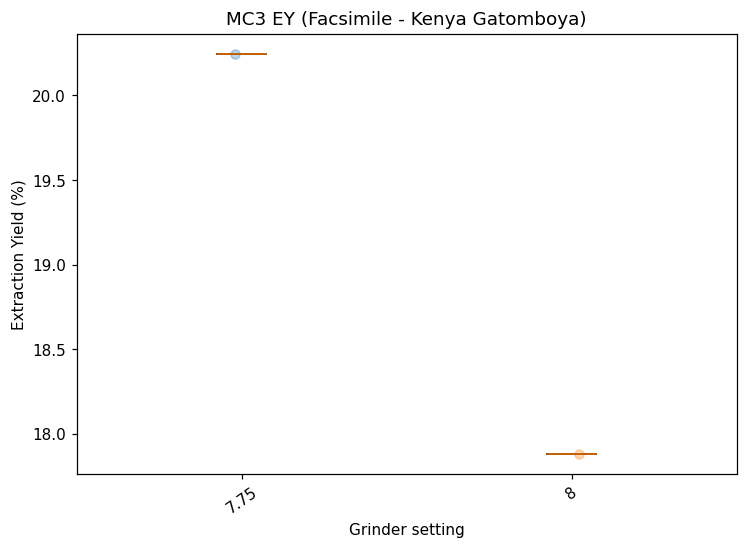

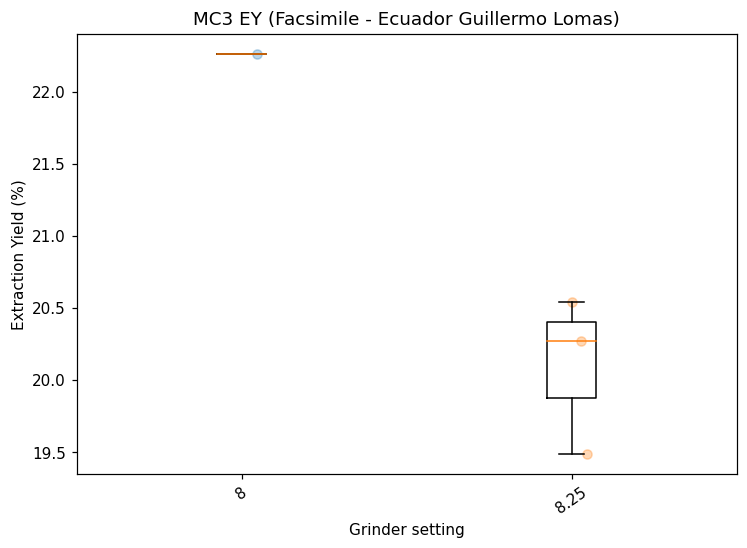

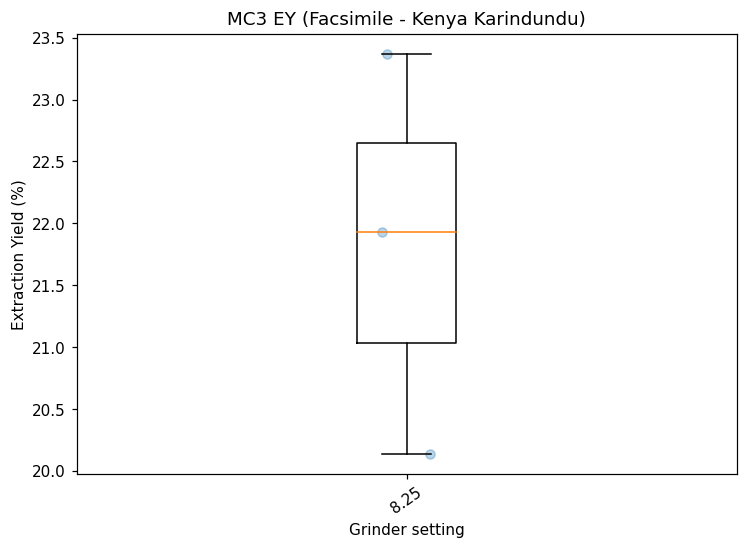

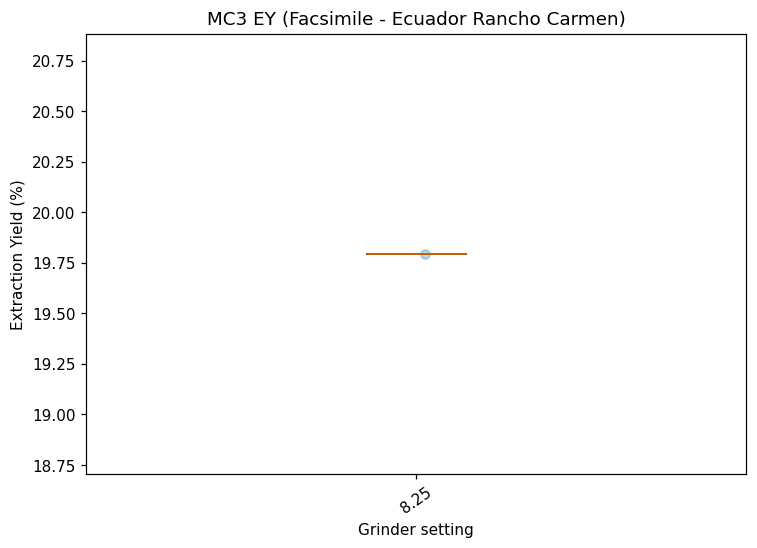

In [7]:
grinders = df.grinder.unique()
def sort_key(x):
    try:
        return float(x)
    except Exception:
        pass
    try:
        return int(x)
    except Exception:
        pass
    return x

for coffee in df.coffee.unique():
    for grinder in grinders:
        columns = []
        times = []
        fig = plt.Figure(dpi=110)
        axe = fig.add_axes([0, 0, 1, 1])
        subdf = df[(df["grinder"] == grinder) & (df["coffee"] == coffee)]
        if subdf.empty:
            continue
        for grind in sorted(subdf.grindersetting.unique(), key=sort_key):
            tds_vals = subdf[subdf["grindersetting"] == grind].extraction_yield.tolist()
            columns.append(grind)
            times.append(tds_vals)
        if len(columns) == 0:
            continue
        axe.boxplot(times, labels=columns)
        i = 0
        uni_range = 0.05
        for column, vals in zip(columns, times):
            center = i+1
            axe.scatter(np.random.uniform(center - uni_range, center + uni_range, len(vals)), vals, alpha=0.3)
            i += 1
        axe.set_xticklabels(columns, rotation=35, ha='center')
        fig.suptitle('')
        axe.set_title(f"{grinder} EY ({coffee})")
        axe.set_ylabel("Extraction Yield (%)")
        axe.set_xlabel("Grinder setting")
        display(fig)